# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

2025-05-17 05:09:04.978407: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 05:09:05.418241: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 05:09:05.877522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747458546.312672    2775 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747458546.415606    2775 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747458547.392185    2775 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Data Ingestion
## Ingesting Data from API -> MongoDB -> Pandas DataFrame

In [2]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv 
import pandas as pd  
load_dotenv() 
PYMONGO_URI = os.getenv("PYMONGO_URI")
API_URI = os.getenv("API_URI")

# Connect to the MongoDB client
client = MongoClient(PYMONGO_URI, tls=True)
db = client['bitcoin_crypto_data']
collection = db['bitcoin_historical_data']
 
try: 
    data = list(collection.find())   
    df = pd.DataFrame(data)  
    if '_id' in df.columns:
        df = df.drop(columns=['_id']) 
    print(df) 
except Exception as e:
    print(f"An error occurred: {e}") 

python-dotenv could not parse statement starting at line 8
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12


     UNIT   TIMESTAMP TYPE MARKET INSTRUMENT           OPEN           HIGH  \
0     DAY  1317340800  267  cadli    BTC-USD       4.788839       5.308179   
1     DAY  1318291200  267  cadli    BTC-USD       4.101192       4.103590   
2     DAY  1318896000  267  cadli    BTC-USD       2.564704       2.882134   
3     DAY  1320019200  267  cadli    BTC-USD       3.269974       3.314105   
4     DAY  1321488000  267  cadli    BTC-USD       2.559723       2.579895   
...   ...         ...  ...    ...        ...            ...            ...   
4995  DAY  1745884800  267  cadli    BTC-USD   95039.773549   95479.643867   
4996  DAY  1745971200  267  cadli    BTC-USD   94298.769728   95256.576007   
4997  DAY  1746489600  267  cadli    BTC-USD   94862.008664   96943.828464   
4998  DAY  1746576000  267  cadli    BTC-USD   96866.220284   97708.055510   
4999  DAY  1747094400  267  cadli    BTC-USD  102801.528591  104972.901638   

                LOW          CLOSE  FIRST_MESSAGE_TIMESTAMP  ..

# Exploratory Data Analysis

In [3]:
df.shape

(5000, 27)

In [4]:
len(df)

5000

In [5]:
df.head()

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
0,DAY,1317340800,267,cadli,BTC-USD,4.788839,5.308179,4.745791,5.140630,1317340980,...,931,42699.737202,214302.165021,42699.737202,214302.165021,41459.069455,208038.786801,41459.069455,208038.786801,2011-09-30
1,DAY,1318291200,267,cadli,BTC-USD,4.101192,4.103590,3.853023,3.951453,1318291320,...,852,43275.627511,171031.376246,43275.627511,171031.376246,41104.077169,162268.540852,41104.077169,162268.540852,2011-10-11
2,DAY,1318896000,267,cadli,BTC-USD,2.564704,2.882134,2.312264,2.419010,1318896000,...,979,91528.591539,239482.758213,91528.591539,239482.758213,87859.091704,229826.441668,87859.091704,229826.441668,2011-10-18
3,DAY,1320019200,267,cadli,BTC-USD,3.269974,3.314105,3.066025,3.247988,1320019200,...,888,32099.911936,102277.778512,32099.911936,102277.778512,30980.524908,98715.595295,30980.524908,98715.595295,2011-10-31
4,DAY,1321488000,267,cadli,BTC-USD,2.559723,2.579895,2.115849,2.250467,1321488000,...,971,100956.507375,229595.784291,100956.507375,229595.784291,94837.321662,215385.548236,94837.321662,215385.548236,2011-11-17


In [6]:
df.tail()

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
4995,DAY,1745884800,267,cadli,BTC-USD,95039.773549,95479.643867,93797.110420,94298.769728,1745884800,...,874715,179941.908855,1.706720e+10,92829.111155,8.806089e+09,21542.721382,2.043894e+09,17521.347825,1.662658e+09,2025-04-29
4996,DAY,1745971200,267,cadli,BTC-USD,94298.769728,95256.576007,93017.834736,94210.990854,1745971200,...,803134,185579.588635,1.750781e+10,103230.329996,9.735107e+09,25890.688394,2.439996e+09,22114.148580,2.083752e+09,2025-04-30
4997,DAY,1746489600,267,cadli,BTC-USD,94862.008664,96943.828464,93460.715271,96866.220284,1746489600,...,878624,173642.623255,1.645068e+10,96055.907664,9.102304e+09,22784.561503,2.157437e+09,18978.824129,1.796991e+09,2025-05-06
4998,DAY,1746576000,267,cadli,BTC-USD,96866.220284,97708.055510,95848.264474,97073.375512,1746576000,...,930291,182380.131449,1.766421e+10,96504.816721,9.345807e+09,24380.492344,2.360430e+09,20481.543229,1.982805e+09,2025-05-07
4999,DAY,1747094400,267,cadli,BTC-USD,102801.528591,104972.901638,101483.838703,104119.197358,1747094400,...,271417,217821.587436,2.252329e+10,108306.608587,1.120183e+10,25902.996897,2.682768e+09,20963.955428,2.172031e+09,2025-05-13


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   UNIT                          5000 non-null   object        
 1   TIMESTAMP                     5000 non-null   int64         
 2   TYPE                          5000 non-null   object        
 3   MARKET                        5000 non-null   object        
 4   INSTRUMENT                    5000 non-null   object        
 5   OPEN                          5000 non-null   float64       
 6   HIGH                          5000 non-null   float64       
 7   LOW                           5000 non-null   float64       
 8   CLOSE                         5000 non-null   float64       
 9   FIRST_MESSAGE_TIMESTAMP       5000 non-null   int64         
 10  LAST_MESSAGE_TIMESTAMP        5000 non-null   int64         
 11  FIRST_MESSAGE_VALUE           

In [8]:
df.describe()

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP,FIRST_MESSAGE_VALUE,HIGH_MESSAGE_VALUE,HIGH_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,...,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5000.000000,5.000000e+03,5000
mean,1.531397e+09,17281.991734,17681.261049,16866.442239,17302.794493,1.531397e+09,1.531483e+09,17281.624358,17681.015017,1.531439e+09,...,1.406243e+05,2.748141e+05,6.746727e+09,1.324830e+05,3.366310e+09,61484.916965,1.054725e+09,50256.314015,7.976498e+08,2018-07-12 12:00:00
min,1.315440e+09,2.050135,2.249777,2.001710,2.050135,1.315440e+09,1.315526e+09,2.113384,2.249777,1.315440e+09,...,2.470000e+02,1.054983e+03,2.983975e+04,7.756034e+02,2.983975e+04,775.603431,2.888803e+04,775.603431,2.888803e+04,2011-09-08 00:00:00
25%,1.423418e+09,391.596754,407.906074,378.589229,392.038706,1.423418e+09,1.423505e+09,392.042267,407.906074,1.423431e+09,...,1.427000e+03,5.267332e+04,1.171814e+07,4.125951e+04,1.040312e+07,27103.455822,9.876018e+06,22065.644137,9.613345e+06,2015-02-08 18:00:00
50%,1.531397e+09,6462.552506,6583.344730,6369.263203,6467.647525,1.531397e+09,1.531483e+09,6460.414804,6581.940151,1.531430e+09,...,1.440000e+03,2.027462e+05,1.604003e+09,9.649730e+04,6.366151e+08,46355.992922,3.069448e+08,37176.278119,2.238842e+08,2018-07-12 12:00:00
75%,1.639375e+09,27007.159350,27430.272615,26671.899532,27033.562543,1.639375e+09,1.639462e+09,26998.303263,27430.272615,1.639395e+09,...,1.440000e+03,3.748556e+05,1.117205e+10,1.755483e+05,4.984816e+09,78825.663964,1.422304e+09,62433.329670,9.894248e+08,2021-12-13 06:00:00
max,1.747354e+09,106188.135939,109134.786742,105395.742955,106188.135939,1.747354e+09,1.747377e+09,106188.135791,109134.786742,1.747363e+09,...,2.054717e+06,3.137129e+06,1.047658e+11,1.503283e+06,7.652634e+10,614241.111991,1.435622e+10,598191.019798,1.229354e+10,2025-05-16 00:00:00
std,1.247201e+08,24322.564165,24834.932614,23799.117548,24352.248981,1.247201e+08,1.247201e+08,24323.268302,24834.817829,1.247214e+08,...,4.068029e+05,2.929089e+05,1.009233e+10,1.350552e+05,5.622004e+09,54127.933451,1.700373e+09,46220.078647,1.386625e+09,NaN


### Missing Values
#### Checking null values

In [9]:
df.isnull().sum()

UNIT                            0
TIMESTAMP                       0
TYPE                            0
MARKET                          0
INSTRUMENT                      0
OPEN                            0
HIGH                            0
LOW                             0
CLOSE                           0
FIRST_MESSAGE_TIMESTAMP         0
LAST_MESSAGE_TIMESTAMP          0
FIRST_MESSAGE_VALUE             0
HIGH_MESSAGE_VALUE              0
HIGH_MESSAGE_TIMESTAMP          0
LOW_MESSAGE_VALUE               0
LOW_MESSAGE_TIMESTAMP           0
LAST_MESSAGE_VALUE              0
TOTAL_INDEX_UPDATES             0
VOLUME                          0
QUOTE_VOLUME                    0
VOLUME_TOP_TIER                 0
QUOTE_VOLUME_TOP_TIER           0
VOLUME_DIRECT                   0
QUOTE_VOLUME_DIRECT             0
VOLUME_TOP_TIER_DIRECT          0
QUOTE_VOLUME_TOP_TIER_DIRECT    0
DATE                            0
dtype: int64

# Data Cleaning

In [10]:
# Dropping Unnecessary columns 
columns_to_drop = [
            'UNIT','TIMESTAMP', 'VOLUME', 'QUOTE_VOLUME',
            'TYPE', 'MARKET', 'INSTRUMENT', 
            'FIRST_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_TIMESTAMP', 
            'FIRST_MESSAGE_VALUE', 'HIGH_MESSAGE_VALUE', 'HIGH_MESSAGE_TIMESTAMP', 
            'LOW_MESSAGE_VALUE', 'LOW_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_VALUE', 
            'TOTAL_INDEX_UPDATES', 'VOLUME_TOP_TIER', 'QUOTE_VOLUME_TOP_TIER', 
            'VOLUME_DIRECT', 'QUOTE_VOLUME_DIRECT', 'VOLUME_TOP_TIER_DIRECT', 
            'QUOTE_VOLUME_TOP_TIER_DIRECT'
        ]

cleaned_data = df.drop(columns=columns_to_drop, errors='ignore')

cleaned_data = cleaned_data.set_index('DATE').sort_index()

In [11]:
cleaned_data.shape

(5000, 4)

In [12]:
cleaned_data.head()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2011-09-08,7.186523,7.196992,6.526702,6.526702
2011-09-09,6.526702,6.526702,4.260291,5.031691
2011-09-10,5.031691,5.436745,4.650752,4.773901
2011-09-11,4.773901,7.088052,4.538431,4.895557
2011-09-12,4.895557,6.187760,4.895557,6.054304


# Feature Engineering

In [13]:
cleaned_data['SMA_20'] = cleaned_data['CLOSE'].rolling(window=20).mean()
cleaned_data['SMA_50'] = cleaned_data['CLOSE'].rolling(window=50).mean()
cleaned_data['EMA_20'] = cleaned_data['CLOSE'].ewm(span=20, adjust=False).mean()

# Price difference features
cleaned_data['OPEN_CLOSE_diff'] = cleaned_data['OPEN'] - cleaned_data['CLOSE']
cleaned_data['HIGH_LOW_diff'] = cleaned_data['HIGH'] - cleaned_data['LOW']
cleaned_data['HIGH_OPEN_diff'] = cleaned_data['HIGH'] - cleaned_data['OPEN']
cleaned_data['CLOSE_LOW_diff'] = cleaned_data['CLOSE'] - cleaned_data['LOW']

# # Lagged features
# cleaned_data['OPEN_lag1'] = cleaned_data['OPEN'].shift(1)
# cleaned_data['CLOSE_lag1'] = cleaned_data['CLOSE'].shift(1)
# cleaned_data['HIGH_lag1'] = cleaned_data['HIGH'].shift(1)
# cleaned_data['LOW_lag1'] = cleaned_data['LOW'].shift(1)

# Rolling statistics
cleaned_data['CLOSE_roll_mean_14'] = cleaned_data['CLOSE'].rolling(window=14).mean()
cleaned_data['CLOSE_roll_std_14']  = cleaned_data['CLOSE'].rolling(window=14).std()

# Log transform for the target
cleaned_data['LogClose'] = np.log1p(cleaned_data['CLOSE'])



In [15]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2011-09-08 to 2025-05-16
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OPEN                5000 non-null   float64
 1   HIGH                5000 non-null   float64
 2   LOW                 5000 non-null   float64
 3   CLOSE               5000 non-null   float64
 4   SMA_20              4981 non-null   float64
 5   SMA_50              4951 non-null   float64
 6   EMA_20              5000 non-null   float64
 7   OPEN_CLOSE_diff     5000 non-null   float64
 8   HIGH_LOW_diff       5000 non-null   float64
 9   HIGH_OPEN_diff      5000 non-null   float64
 10  CLOSE_LOW_diff      5000 non-null   float64
 11  CLOSE_roll_mean_14  4987 non-null   float64
 12  CLOSE_roll_std_14   4987 non-null   float64
 13  LogClose            5000 non-null   float64
dtypes: float64(14)
memory usage: 585.9 KB


In [16]:
# Drop rows that contain NaN (due to rolling/lags)
cleaned_data.dropna(inplace=True)

In [17]:
cleaned_data.head()

,OPEN,HIGH,LOW,CLOSE,SMA_20,SMA_50,EMA_20,OPEN_CLOSE_diff,HIGH_LOW_diff,HIGH_OPEN_diff,CLOSE_LOW_diff,CLOSE_roll_mean_14,CLOSE_roll_std_14,LogClose
DATE,,,,,,,,,,,,,,
2011-10-27,2.771939,3.083389,2.765258,3.040003,3.267857,4.422642,3.294616,-0.268064,0.318131,0.311449,0.274745,2.928434,0.552692,1.396245
2011-10-28,3.040003,3.246847,2.920357,3.189995,3.226980,4.355908,3.284652,-0.149992,0.326490,0.206844,0.269638,2.870930,0.468677,1.432700
2011-10-29,3.189995,3.788149,3.145182,3.582187,3.200977,4.326918,3.312989,-0.392192,0.642967,0.598154,0.437005,2.852356,0.430850,1.522176
2011-10-30,3.582187,3.650200,3.200620,3.269974,3.159416,4.296839,3.308892,0.312213,0.449580,0.068013,0.069354,2.831357,0.399523,1.451608
2011-10-31,3.269974,3.314105,3.066025,3.247988,3.124243,4.263888,3.303092,0.021987,0.248080,0.044130,0.181962,2.880163,0.406124,1.446445


In [19]:
cleaned_data.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'SMA_20', 'SMA_50', 'EMA_20',
       'OPEN_CLOSE_diff', 'HIGH_LOW_diff', 'HIGH_OPEN_diff', 'CLOSE_LOW_diff',
       'CLOSE_roll_mean_14', 'CLOSE_roll_std_14', 'LogClose'],
      dtype='object')

In [20]:
# feature_cols = [
#             'LogClose', 'SMA_20', 'SMA_50', 'EMA_20',
#             'OPEN_CLOSE_diff', 'HIGH_LOW_diff', 'HIGH_OPEN_diff', 'CLOSE_LOW_diff',
#             'OPEN_lag1', 'CLOSE_lag1', 'HIGH_lag1', 'LOW_lag1',
#             'CLOSE_roll_mean_14', 'CLOSE_roll_std_14'
#         ]
feature_cols = [
            'LogClose', 'SMA_20', 'SMA_50', 'EMA_20',
            'OPEN_CLOSE_diff', 'HIGH_LOW_diff', 'HIGH_OPEN_diff', 'CLOSE_LOW_diff', 
            'CLOSE_roll_mean_14', 'CLOSE_roll_std_14'
        ]
window_size = 30

X_all = cleaned_data[feature_cols].values
y_all = cleaned_data['LogClose'].values

X_seq, y_seq = [], []
for i in range(window_size, len(X_all)):
    X_seq.append(X_all[i - window_size:i])
    y_seq.append(y_all[i])

X_raw = np.array(X_seq)
y_raw = np.array(y_seq)
dates = cleaned_data.index[30:]

In [21]:
X_raw.shape

(4921, 30, 10)

In [22]:
y_raw.shape

(4921,)

**Explanation of the Features**

1. **LogClose**  
   - The natural logarithm of the (Close + 1) price, computed as `np.log1p(CLOSE)`.  
   - This transformation helps reduce skewness and stabilizes variance, making the data more suitable for modeling.

2. **SMA_20**  
   - The 20-period Simple Moving Average of the closing price.  
   - Indicates the short-term trend by averaging the closing prices over the last 20 days.

3. **SMA_50**  
   - The 50-period Simple Moving Average of the closing price.  
   - Provides a medium-term trend indicator by smoothing out price fluctuations over 50 days.

4. **EMA_20**  
   - The 20-period Exponential Moving Average of the closing price.  
   - Similar to the SMA, but gives more weight to recent prices, making it more responsive to recent changes.

5. **OPEN_CLOSE_diff**  
   - The difference between the opening price and the closing price (`OPEN - CLOSE`).  
   - Captures the daily price movement from market open to close.

6. **HIGH_LOW_diff**  
   - The difference between the high and low prices of the day (`HIGH - LOW`).  
   - Represents the intraday price range and overall volatility.

7. **HIGH_OPEN_diff**  
   - The difference between the high and opening prices (`HIGH - OPEN`).  
   - Highlights the upward movement from the opening price during the day.

8. **CLOSE_LOW_diff**  
   - The difference between the closing price and the low price (`CLOSE - LOW`).  
   - Highlights the upward movement from the day’s low to the closing price.

9. **OPEN_lag1**  
   - The opening price from the previous day.  
   - Captures temporal dependency in the opening prices.

10. **CLOSE_lag1**  
    - The closing price from the previous day.  
    - Helps capture short-term price momentum.

11. **HIGH_lag1**  
    - The highest price from the previous day.  
    - Useful for capturing recent peak values in the price sequence.

12. **LOW_lag1**  
    - The lowest price from the previous day.  
    - Useful for capturing recent trough values in the price sequence.

13. **CLOSE_roll_mean_14**  
    - The 14-period rolling mean of the closing price.  
    - Summarizes the recent average closing price over the last 14 days.

14. **CLOSE_roll_std_14**  
    - The 14-period rolling standard deviation of the closing price.  
    - Measures the volatility of the closing price over the last 14 days.


# Data Visualization

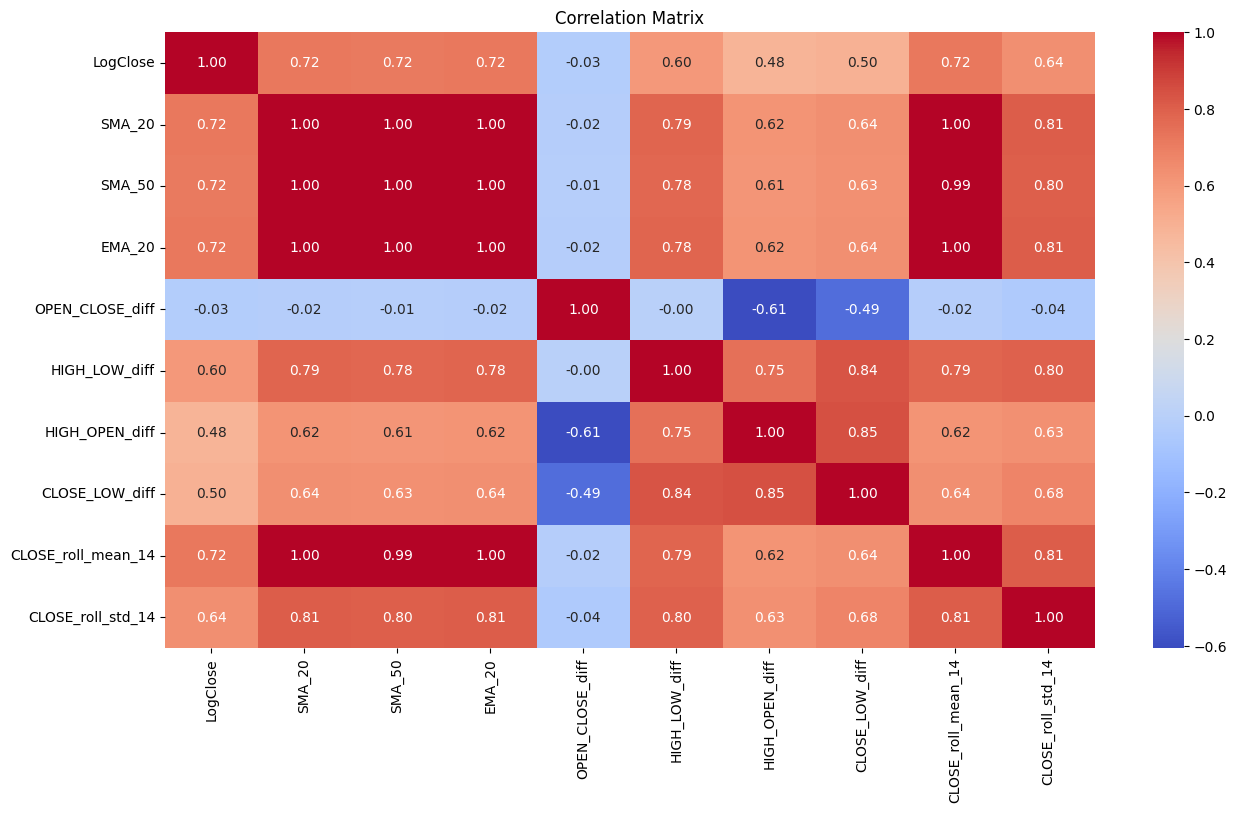

In [23]:
# Compute correlation matrix
correlation_matrix = cleaned_data[feature_cols].corr()

# Visualize correlation
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Data Splitting
## Train-Test Split and Scaling the data

In [24]:
train_frac=0.8
val_frac=0.1

total_samples = len(X_raw)
train_size = int(train_frac * total_samples)
val_size   = int(val_frac * total_samples)

# Train/Val/Test Split
X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]
dates_train = dates[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]
dates_val   = dates[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]
dates_test  = dates[train_size + val_size:]

print(f"X_train_raw: {X_train_raw.shape}, X_val_raw: {X_val_raw.shape}, X_test_raw: {X_test_raw.shape}, y_train_raw: {y_train_raw.shape}, y_val_raw: {y_val_raw.shape}, y_test_raw: {y_test_raw.shape}")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on TRAIN only for features (reshape to 2D for scaling)
X_train_2d = X_train_raw.reshape(-1, X_train_raw.shape[2])
scaler_X.fit(X_train_2d)

X_train_final = scaler_X.transform(X_train_2d).reshape(X_train_raw.shape)
X_val_final  = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[2])).reshape(X_val_raw.shape)
X_test_final  = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[2])).reshape(X_test_raw.shape)

# Scale target values if needed (not returned)
y_train_2d = y_train_raw.reshape(-1, 1)
scaler_y.fit(y_train_2d)
y_train_final = scaler_y.transform(y_train_2d).flatten()
y_val_final  = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
y_test_final  = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

print(f"X_train_scaled: {X_train_final.shape}, X_val_scaled: {X_val_final.shape}, X_test_scaled: {X_test_final.shape}, y_train_scaled: {y_train_final.shape}, y_val_scaled: {y_val_final.shape}, y_test_scaled: {y_test_final.shape}")


X_train_raw: (3936, 30, 10), X_val_raw: (492, 30, 10), X_test_raw: (493, 30, 10), y_train_raw: (3936,), y_val_raw: (492,), y_test_raw: (493,)
X_train_scaled: (3936, 30, 10), X_val_scaled: (492, 30, 10), X_test_scaled: (493, 30, 10), y_train_scaled: (3936,), y_val_scaled: (492,), y_test_scaled: (493,)


# Model Training

In [25]:
l2_reg = tf.keras.regularizers.l2(1e-4)
dropout_rate = 0.3

# Determine window_size and number of features from X_train
window_size = X_train_final.shape[1]
num_features = X_train_final.shape[2]

model = Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.LSTM(
        64,
        return_sequences=True,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),
    layers.Dropout(dropout_rate),
    layers.LSTM(
        64,
        return_sequences=False,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),
    layers.Dropout(dropout_rate),
    layers.Dense(1)  # outputs scaled LogClose
])

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


2025-05-17 05:11:45.332640: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - loss: 0.2417 - mean_absolute_error: 0.2996 - val_loss: 0.0377 - val_mean_absolute_error: 0.0335 - learning_rate: 5.0000e-04
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0520 - mean_absolute_error: 0.0912 - val_loss: 0.0355 - val_mean_absolute_error: 0.0330 - learning_rate: 5.0000e-04
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0469 - mean_absolute_error: 0.0835 - val_loss: 0.0328 - val_mean_absolute_error: 0.0266 - learning_rate: 5.0000e-04
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0438 - mean_absolute_error: 0.0809 - val_loss: 0.0322 - val_mean_absolute_error: 0.0434 - learning_rate: 5.0000e-04
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0412 - mean_absolute_error: 0.0778 - val_loss: 0.0288 - val_mean_absolute_error: 0.0228 - learning_rate: 5.0000e-04
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0380 - mean_absolute_error: 0.0732 - val

# Model Evaluation

In [26]:
train_preds_scaled = model.predict(X_train_final).flatten()
val_preds_scaled = model.predict(X_val_final).flatten()
test_preds_scaled = model.predict(X_test_final).flatten()

train_preds_log = scaler_y.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
val_preds_log = scaler_y.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
test_preds_log = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()

# Convert back from log scale
train_preds = np.expm1(train_preds_log)
val_preds = np.expm1(val_preds_log)
test_preds = np.expm1(test_preds_log)

y_train_log = scaler_y.inverse_transform(y_train_final.reshape(-1, 1)).flatten()
y_val_log = scaler_y.inverse_transform(y_val_final.reshape(-1, 1)).flatten()
y_test_log = scaler_y.inverse_transform(y_test_final.reshape(-1, 1)).flatten()

y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_val_log)
y_test_orig = np.expm1(y_test_log)

# ------------------------------------------------------
#  Evaluation
# ------------------------------------------------------
train_mse = mean_squared_error(y_train_orig, train_preds)
val_mse = mean_squared_error(y_val_orig, val_preds)
test_mse = mean_squared_error(y_test_orig, test_preds)

train_mae = mean_absolute_error(y_train_orig, train_preds)
val_mae = mean_absolute_error(y_val_orig, val_preds)
test_mae = mean_absolute_error(y_test_orig, test_preds)

train_r2 = r2_score(y_train_orig, train_preds)
val_r2 = r2_score(y_val_orig, val_preds)
test_r2 = r2_score(y_test_orig, test_preds)

logging.info("Training Metrics:")
logging.info(f" - MSE: {train_mse:.4f}")
logging.info(f" - MAE: {train_mae:.4f}")
logging.info(f" - R²:  {train_r2:.4f}")

logging.info("Validation Metrics:")
logging.info(f" - MSE: {val_mse:.4f}")
logging.info(f" - MAE: {val_mae:.4f}")
logging.info(f" - R²:  {val_r2:.4f}")

logging.info("Test Metrics:")
logging.info(f" - MSE: {test_mse:.4f}")
logging.info(f" - MAE: {test_mae:.4f}")
logging.info(f" - R²:  {test_r2:.4f}")

metrics = {
    "train": {
        "MSE": train_mse,
        "MAE": train_mae,
        "R-squared": train_r2
    },
    "validation": {
        "MSE": val_mse,
        "MAE": val_mae,
        "R-squared": val_r2
    },
    "test": {
        "MSE": test_mse,
        "MAE": test_mae,
        "R-squared": test_r2
    }
}
print(metrics)

123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'train': {'MSE': 867111.0068830698, 'MAE': 383.01277547871575, 'R-squared': 0.9962334428140279}, 'validation': {'MSE': 688586.909932206, 'MAE': 613.7972066643539, 'R-squared': 0.9868132877003857}, 'test': {'MSE': 70099774.81845285, 'MAE': 6079.521089355684, 'R-squared': 0.7698661965188653}}


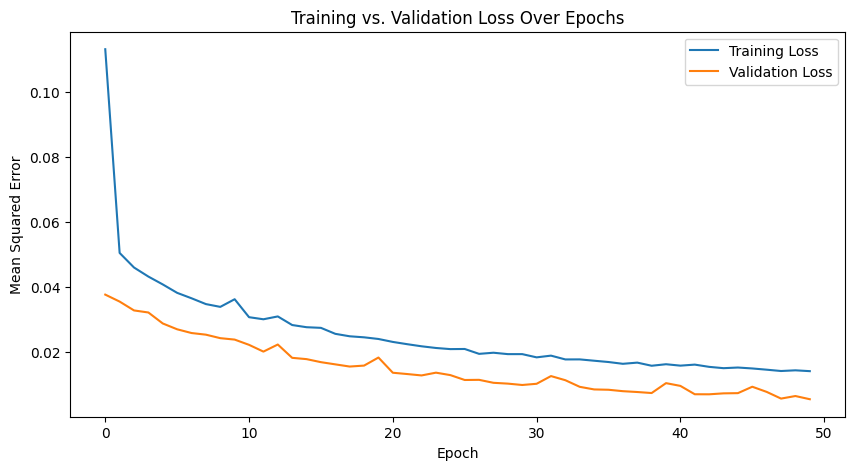

In [27]:
# Assuming 'history' is the History object returned from model.fit()
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

**Observations:**

1. **Convergence Trend:** Both the training loss and validation loss decrease steadily over time, indicating that the model is learning effectively. By around epoch 100, both losses plateau, suggesting the model has reached optimal performance.

2. **No Overfitting:** The validation loss remains consistently lower than the training loss throughout the epochs. This suggests the model is generalizing well to unseen data without signs of overfitting.


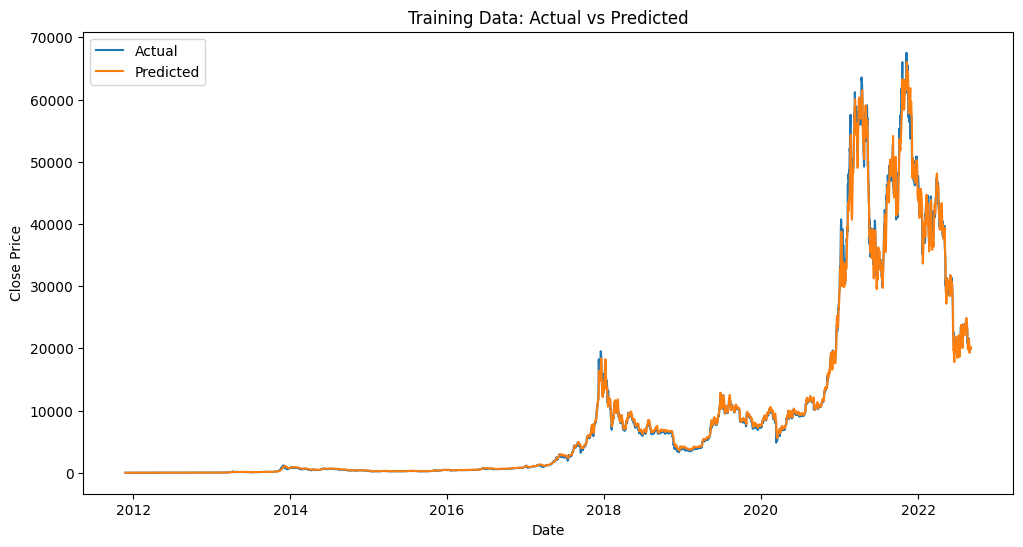

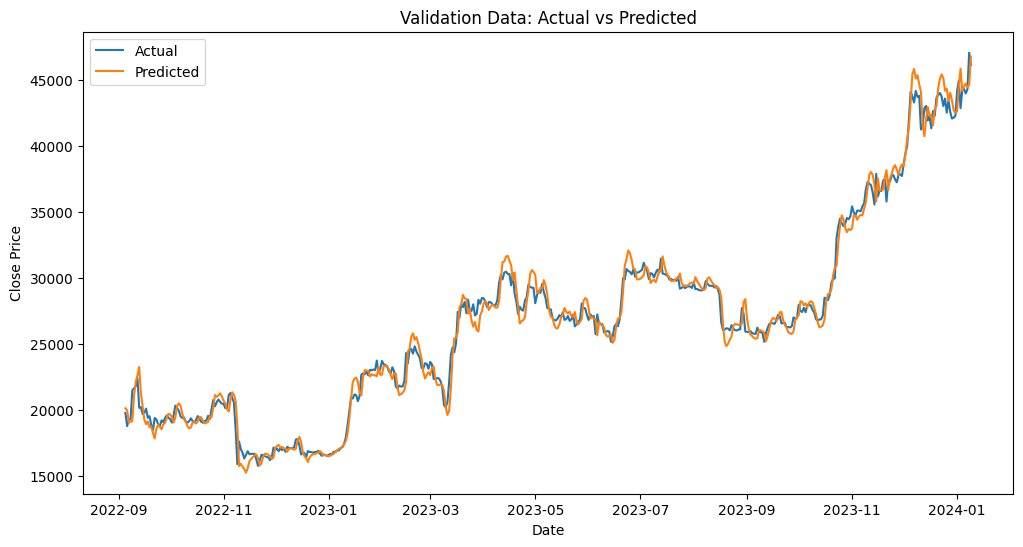

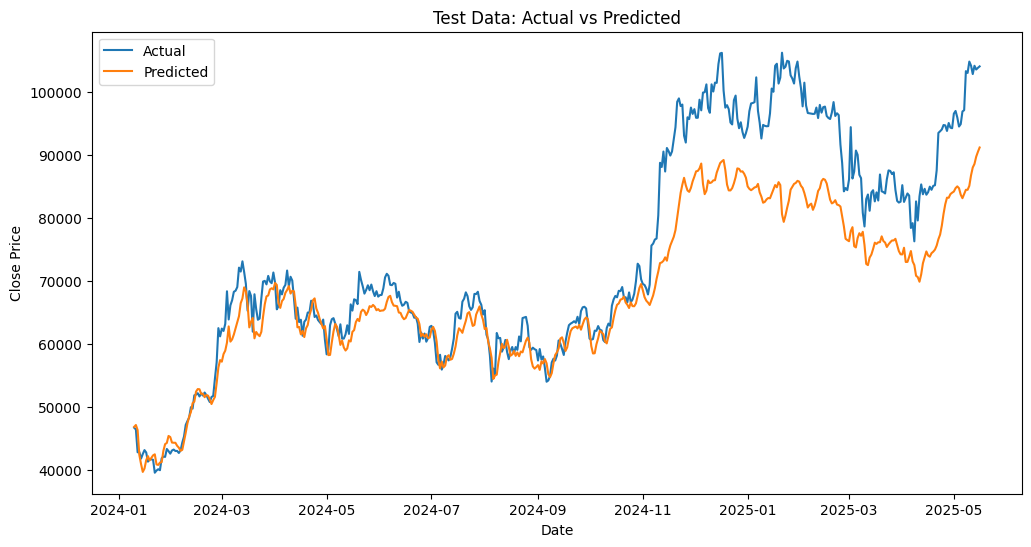

In [28]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train_orig, label="Actual")
plt.plot(dates_train, train_preds, label="Predicted")
plt.title("Training Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
# Plot for Validation Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_val, y_val_orig, label="Actual")
plt.plot(dates_val, val_preds, label="Predicted")
plt.title("Validation Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot for Test Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_orig, label="Actual")
plt.plot(dates_test, test_preds, label="Predicted")
plt.title("Test Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


**Observations:**

1. **Training Data:** The predicted curve closely follows the actual price trend, indicating the model has effectively learned from historical data.

2. **Validation Data:** The model tracks short-term fluctuations well, suggesting it generalizes effectively to unseen data.

3. **Test Data:** Despite some deviations at higher price levels, the predictions still capture the overall upward and downward movements, demonstrating a reasonable forecasting capability.